<a id='table_of_contents'><h1>Содержание проекта:</h1></a>
1. <a href='#project_description'>Описание проекта</a>
1. <a href='#data_description'>Описание данных</a>
1. <a href='#data_loading'>Загрузка и подготовка данных к анализу</a>
    - <a href='#hypothesis'>Гипотезы и их параметры `hypothesis`</a>
    - <a href='#orders'>Информация о заказах `orders`</a>
    - <a href='#visitors'>Информация о визитах `visitors`</a>
1. <a href='#prioritizing'>Приоретизация гипотез</a> 
1. <a href='#ab_test_analyzing'>Анализ A/B-теста</a>

<a id='project_description'><h1>Описание проекта</h1></a>
<br>Проект состоит из 2 частей.
<br>1 часть: Приоритезация гипотез.
<br>Необходимо приоритезировать гипотезы с использованием фреймворков ICE и RICE и сделать выводы.
<br>
<br>2 часть: Анализ A/B теста.
<br>Необходимо проанализировать результаты A/B теста, принять решение о продолжении или остановке теста и сделать выводы.

<a id='data_description'><h1>Описание данных</h1></a>
<a href='#table_of_contents'>В начало</a>

1 часть:

Файл `/datasets/hypothesis.csv`
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

2 часть:

Файл `/datasets/orders.csv`
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv`
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

<a id='data_loading'><h1>Загрузка и подготовка данных к анализу</h1></a>
<a href='#table_of_contents'>В начало</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

<a id='hypothesis'><h2>Гипотезы и их параметры `hypothesis`</h2></a>
<a href='#table_of_contents'>В начало</a>

1. Прочитаем данные из файла.
1. Приведем столбцы к нижнему регистру.

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.columns = map(str.lower, hypothesis.columns)

In [3]:
hypothesis.style

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<a id='orders'><h2>Информация о заказах `orders`</h2></a>
<a href='#table_of_contents'>В начало</a>

1. Прочитаем данные из файла.
1. Приведем столбец `date` к типу datetime.
1. Переименуем столбцы `transactionId` и `visitorId` в `transaction_id`, `buyer_id`.

In [4]:
orders = pd.read_csv('/datasets/orders.csv', 
                     parse_dates=['date'], 
                     names=['transaction_id', 'buyer_id', 'date', 'revenue', 'group'], 
                     header=0)

In [5]:
orders.head()

,transaction_id,buyer_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1197 non-null int64
buyer_id          1197 non-null int64
date              1197 non-null datetime64[ns]
revenue           1197 non-null int64
group             1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


В данных отсутствуют пропущенные значения.

<a id='visitors'><h2>Информация о визитах `visitors`</h2></a>
<a href='#table_of_contents'>В начало</a>

1. Прочитаем данные из файла.
1. Приведем столбец `date` к типу datetime.

In [7]:
visitors = pd.read_csv('/datasets/visitors.csv', parse_dates=['date'])
visitors.columns = map(str.lower, visitors.columns)

In [8]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [9]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


В данных отсутствуют пропущенные значения.

<a id='prioritizing'><h1>Приоритизация гипотез</h1></a>
<a href='#table_of_contents'>В начало</a>

In [10]:
hypothesis.style.format({'hypothesis': '{:>10}'})

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


----
### Применим фреймворк ICE для приоритизации гипотез и отсортируем их по убыванию приоритета.

$$ICE =\frac{Impact * Confidence}{Efforts}$$

In [11]:
ice = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round().astype('int')
col_index = 1

hypothesis.insert(loc=1, value=ice, column='ice')

In [12]:
hypothesis.sort_values(by='ice', ascending=False).style

,hypothesis,ice,reach,impact,confidence,efforts
8,"Запустить акцию, дающую скидку на товар в день рождения",16,1,9,9,5
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13,3,10,8,6
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11,10,7,8,5
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8,5,3,8,3
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7,8,3,7,3
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,2,5,4,10
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1,8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1,3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1,3,2,2,3


### ℹ️ После приоретизации по ICE в топ-5 попали гипотезы 8, 0, 7, 6, 2, у остальных гипотез рейтинг значительно ниже.

----
### Применим фреймворк RICE для приоритизации гипотез и отсортируем по убыванию приоритета.

$$RICE = \frac{Reach * Impact * Convidence}{Efforts}$$

In [13]:
rice = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']/hypothesis['efforts']).round().astype('int')
col_index = 1

hypothesis.insert(loc=1, value=rice, column='rice')

In [14]:
hypothesis.sort_values(by='rice', ascending=False).style

,hypothesis,rice,ice,reach,impact,confidence,efforts
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112,11,10,7,8,5
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56,7,8,3,7,3
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40,13,3,10,8,6
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40,8,5,3,8,3
8,"Запустить акцию, дающую скидку на товар в день рождения",16,16,1,9,9,5
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9,1,8,3,3,8
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4,2,2,5,4,10
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4,1,3,2,2,3
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,3,1,1,1


### ℹ️После приоретизации по RICE в топ-5 попали гипотезы 7, 2, 0, 6, 8, у остальных гипотез рейтинг значительно ниже.

----
### Как изменилась приоритизация гипотез при применении RICE вместо ICE.

После приоретизации по RICE гипотеза 8, у которой был максимальный рейтирг в ICE, опустилась на 5 место, за счет того, что ее охват будет самым низким. 

Тогда как гипотеза 7, которая была 3 в рейтинге ICE с большим отрывом по очкамм поднялась на 1 место в RICE. 

То же самое произошло с гипотезой 2, благодаря высокому значению охвата, в RICE эта гипотеза поднялась с 5 на 2 место.

----

- При проверке гипотезы важно учитывать объем аудитории, которую она затронет, от этого зависит насколько большой эффект будет получен. 
- Гипотезы с широким охватом можно будет проверить точнее и в более короткие сроки.
- При приоретизации гипотез мы будем использовать RICE. Однако, здесь важно насколько возможно четко определить реальный охват для гипотезы.

<a id='ab_test_analyzing'><h1>Анализ A/B-теста</h1></a>
<a href='#table_of_contents'>В начало</a>

Проанализируйте A/B-тест:
1. [x] <a href='#1'>Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.</a>
1. [x] <a href='#2'>Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.</a>
1. [x] <a href='#3'>Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.</a>
1. [x] <a href='#4'>Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.</a>
1. [x] <a href='#5'>Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.</a>
1. [x] <a href='#6'>Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.</a>
1. [x] <a href='#7'>Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.</a>
1. [x] <a href='#8'>Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.</a>
1. [x] <a href='#9'>Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.</a>
1. [x] <a href='#10'>Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.</a>
1. [x] <a href='#11'>Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.</a>
1. [x] <a href='#12'>Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.</a>
1. [x] <a href='#13'>Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.</a>
1. [x] <a href='#14'>Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.</a>

<a id='1'><h2>1. График кумулятивной выручки по группам</h2></a>
<a href='#table_of_contents'>В начало</a>

### Для каждой пары Дата+Группа рассчитаем куммулятивное значение выручки и куммулятивное значение количества заказов.

In [15]:
# выберем уникальные пары дата+группа и удалим дубликаты
datesGroups = orders[['date', 'group']].drop_duplicates()

# для каждой пары дата+группа посчитаем куммулятивное значение выручки и количества заказов
ordersAggregated = datesGroups.apply(lambda x: \
orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date': 'max', 
      'group': 'max', 
      'revenue': 'sum', 
      'buyer_id': pd.Series.nunique, 
      'transaction_id': pd.Series.nunique}), axis=1)\
.sort_values(by=['date', 'group'])\
.rename(columns={"buyer_id": "buyers", 
                 "transaction_id": "transactions"})

In [16]:
ordersAggregated.head()

,date,group,revenue,buyers,transactions
55,2019-08-01,A,148579,20,24
66,2019-08-01,B,101217,20,21
175,2019-08-02,A,242401,38,44
173,2019-08-02,B,266748,43,45
291,2019-08-03,A,354874,62,68


### Сформируем сводную таблицу, где в строках даты, в столбцах группы, в ячейках куммулятивное значение выручки на день.

In [17]:
cum_revenue = ordersAggregated.pivot_table(index='date', columns='group', values='revenue', aggfunc='sum')
cum_revenue.columns = ['A', 'B']

In [18]:
cum_revenue.head()

,A,B
date,,
2019-08-01,148579,101217
2019-08-02,242401,266748
2019-08-03,354874,380996
2019-08-04,425699,489567
2019-08-05,549917,581995


### Выведем значения куммулятивной выручки по группам на график.

In [19]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

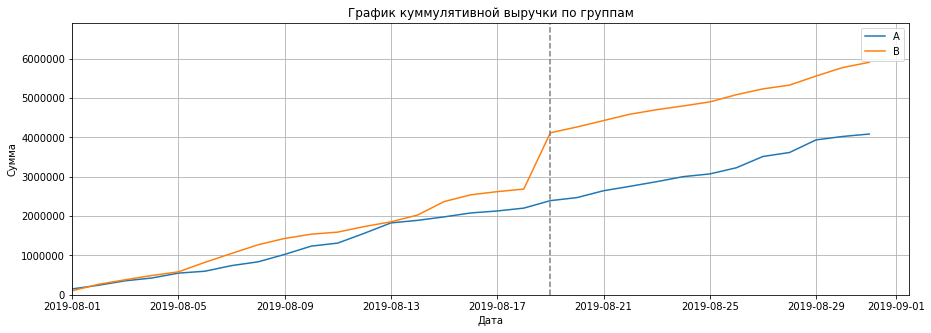

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(cum_revenue.index, cum_revenue['A'], label='A')
plt.plot(cum_revenue.index, cum_revenue['B'], label='B')
plt.title('График куммулятивной выручки по группам')
plt.grid(True)
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Сумма')
plt.xlim(left=cum_revenue.index[0])
plt.ylim((0, \
          max(cum_revenue['A'].max(), cum_revenue['B'].max())+1e6))
plt.axvline(x='2019-08-19 00:00:00', color='gray', linestyle='--')
plt.show()

---

<div class="alert alert-block alert-warning">
    

### Комментарий ревьюера


Чтобы убрать техническую информацию от `matplotlib`, можно использовать метод `plt.show()` или поставить после инициализации графика `;`
</div>

---

----
ℹ️ На графике куммулятивной выручки виден резкий скачок 19.08.2019 в группе B, вероятнее всего связанный с крупной покупкой в этой группе, из-за чего существенно выросло различие между двумя группами.

<a id='2'><h2>2. График кумулятивного среднего чека по группам</h2></a>
<a href='#table_of_contents'>В начало</a>

Рассчитаем средний чек по группам, для этого куммулятивную выручку разделим на количество заказов на этот день. 

$$average\_check = \frac{revenue}{orders}$$

### Сформируем сводную таблицу, где в строках даты, в столбцах группы, в ячейках куммулятивное значение количества заказов на день.

In [21]:
cum_orders = ordersAggregated.pivot_table(index='date', columns='group', values='transactions', aggfunc='sum')
cum_orders.columns = ['A', 'B']
cum_orders.head()

,A,B
date,,
2019-08-01,24,21
2019-08-02,44,45
2019-08-03,68,61
2019-08-04,84,78
2019-08-05,109,101


### Рассчитаем средний чек по группам по дням.

In [22]:
avg_check = (cum_revenue/cum_orders).round(2)

In [23]:
avg_check.head(3)

,A,B
date,,
2019-08-01,6190.79,4819.86
2019-08-02,5509.11,5927.73
2019-08-03,5218.74,6245.84


### Выведем значение куммулятивного среднего чека на график.

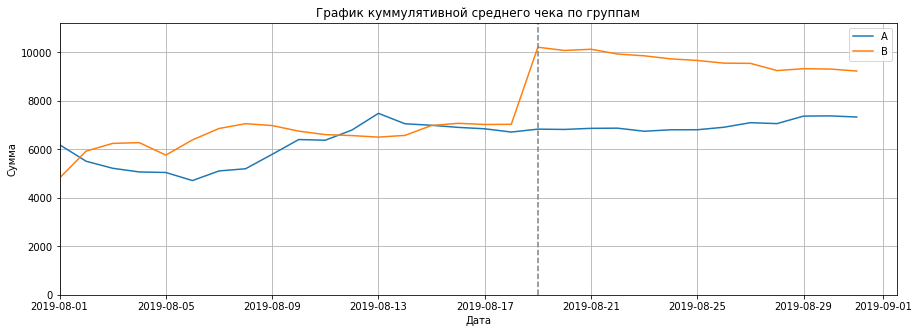

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(avg_check.index, avg_check['A'], label='A')
plt.plot(avg_check.index, avg_check['B'], label='B')
plt.title('График куммулятивной среднего чека по группам')
plt.grid(True)
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Сумма')
plt.xlim(left=avg_check.index[0])
plt.ylim((0, \
          max(avg_check['A'].max(), avg_check['B'].max())+1e3))
plt.axvline(x='2019-08-19 00:00:00', color='gray', linestyle='--', 
            in_layout=True, label='09', visible=True, markevery=1000, gid='kjkj', )
plt.show()

----
ℹ️ На графике куммулятивного среднего чека, также как на графике куммулятивной выручки, виден резкий скачок 19.08.2019 в группе B, вероятнее всего связанный с крупной покупкой в группе. Есть чуть более резкие, чем обычно изменения в группе Б - 05.08.2020 и в группе А - 13.08.2020.

<a id='3'><h2>3. График относительного изменения кумулятивного среднего чека группы B к группе A</h2></a>
<a href='#table_of_contents'>В начало</a>

Рассчитаем относительное различие для среднего чека. Если значение "-" значит значение в группе B ниже, чем в группе A, если "+" - наоборот.

$$relative\_difference\_averege\_check = \frac{averege\_check\_B}{averege\_check\_A} - 1$$

In [25]:
avg_check['rel_dif'] = avg_check['B']/avg_check['A'] - 1
#avg_check.head()

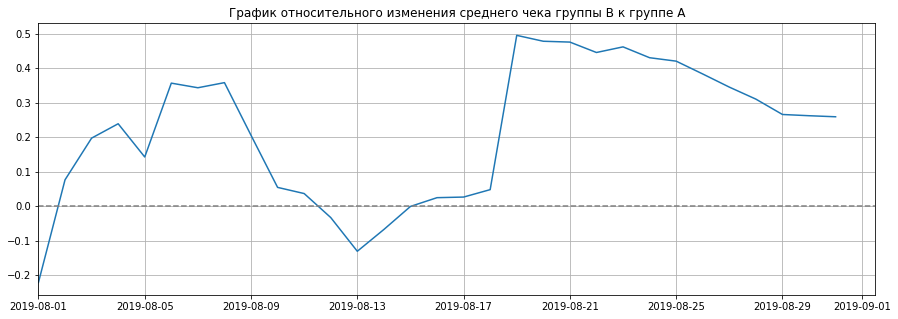

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(avg_check.index, avg_check['rel_dif'])
plt.title('График относительного изменения среднего чека группы B к группе A')
plt.grid(True)
plt.xlim(left=avg_check.index[0])
plt.axhline(y=0, color='gray', linestyle='--')

----
ℹ️ На графике видно, что на первой неделе средний чек в группе B относительно группы A рос, затем пошло снижение. 19.08 произошел резкий скачок из-за чего график оказался в положительной зоне, при этом все-таки видна тенденция к снижению. И если бы в данных не появился этот крупный заказ, то линия графика ушла бы в отрицательную зону.

Заметен провал 05.08, когда средний чек по группе B заметно снизился, провал 13.08, когда заметно вырос средний чек по группе A

<a id='4'><h2>4. График кумулятивной конверсии по группам</h2></a>
<a href='#table_of_contents'>В начало</a>

Рассчитаем конверсию как долю количества заказов в общем количестве визитов.

$$conversion = \frac{orders}{visitors}*100$$

In [27]:
cum_visitors = visitors.pivot_table(index='date', columns='group', values='visitors', aggfunc='sum').cumsum()
#cum_visitors.head(3)

In [28]:
conversion = cum_orders/cum_visitors
#conversion.head()

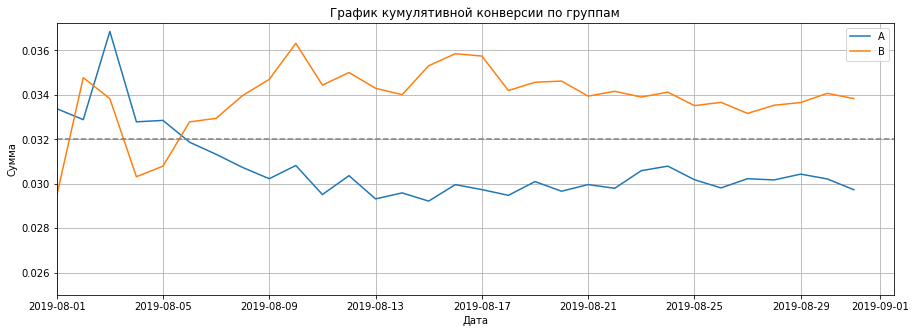

In [29]:
plt.figure(figsize=(15, 5))
plt.plot(conversion.index, conversion['A'], label='A')
plt.plot(conversion.index, conversion['B'], label='B')
plt.legend()
plt.title('График кумулятивной конверсии по группам')
plt.grid(True)
plt.xlabel('Дата')
plt.ylabel('Сумма')
plt.xlim(left=conversion.index[0])
plt.ylim(bottom=0.025)
plt.axhline(y=0.032, color='gray', linestyle='--')
plt.show()

----
ℹ️ В группе A заметен выраженный скачок 03.08, после чего конверсия снизилась и стабилизировалась.

В группе B есть сильный скачок конверсии 02.08 вверх и падение 04.08, затем конверсия группы вырвалась вперед и стабилизировалась

<a id='5'><h2>5. График относительного изменения кумулятивной конверсии группы B к группе A</h2></a>
<a href='#table_of_contents'>В начало</a>

Рассчитаем относительное различие для конверсии. Если значение "-" значение ниже в группе B, если "+" - значение ниже в группе A.

$$relative\_difference\_conversion = \frac{conversion\_B}{conversion\_A} - 1$$

In [30]:
conversion['rel_dif'] = conversion['B']/conversion['A'] - 1

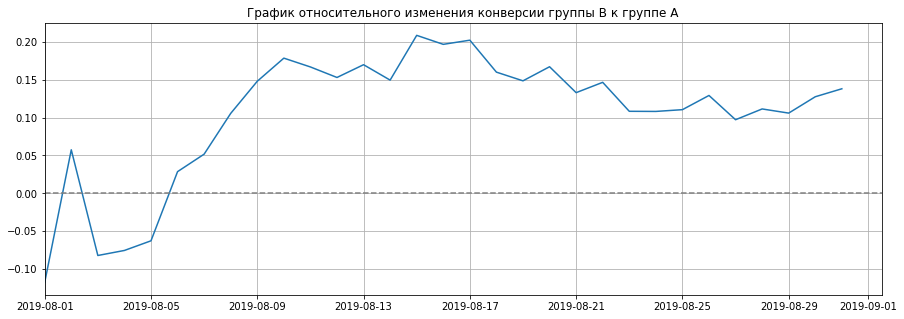

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(conversion.index, conversion['rel_dif'])
plt.title('График относительного изменения конверсии группы B к группе A');
plt.grid(True)
plt.xlim(left=conversion.index[0])
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

----
ℹ️ На графике относительного изменения конверсии видно, что после резкого скачка 02.08, конверсия группы B вырвалась вперед, затем 03.08 произошел резкий спад. После чего, примерно в течение недели шел активный рост, затем конверсия стабилизировалась.

----

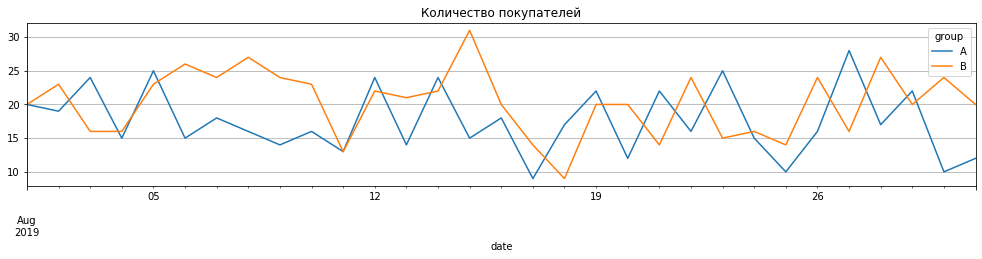

In [32]:
orders.groupby(by=['date', 'group']).agg({'buyer_id': 'nunique'}).\
pivot_table(index='date', columns='group', values='buyer_id', aggfunc='sum').\
plot.line(figsize=(17, 3), grid=True, title='Количество покупателей');

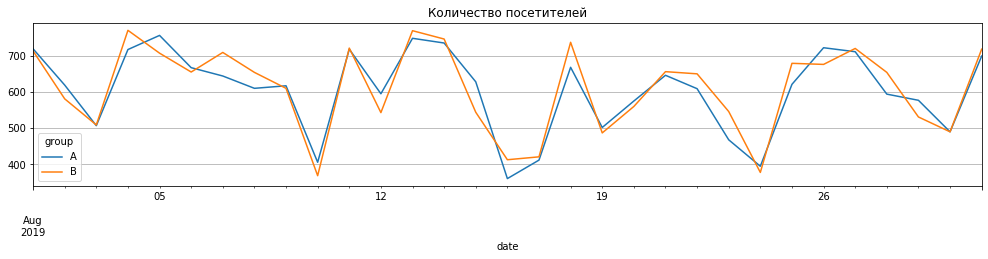

In [33]:
visitors.pivot_table(index='date', columns='group', values='visitors', aggfunc='sum').\
plot.line(figsize=(17, 3), grid=True, title='Количество посетителей');

<a id='6'><h2>6. Точечный график количества заказов по пользователям</h2></a>
<a href='#table_of_contents'>В начало</a>

Сколько заказов приходится на одного покупателя.

In [34]:
ordersByUsers = orders.groupby(['buyer_id'])\
.agg({'transaction_id': 'nunique'})\

In [35]:
#ordersByUsers.sort_values(by='transaction_id', ascending=False).head()

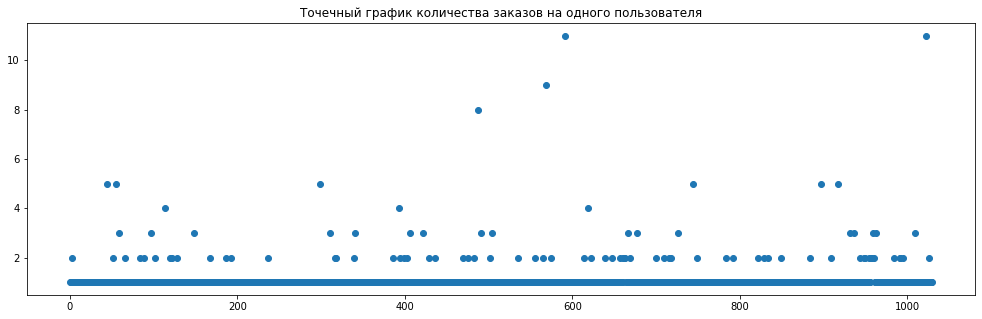

In [36]:
plt.figure(figsize=(17, 5))
plt.title('Точечный график количества заказов на одного пользователя')
plt.scatter(pd.Series(range(0, len(ordersByUsers))), \
            ordersByUsers['transaction_id']);

----
ℹ️ Основная часть покупала 1-5 раз. Рассчитаем выборочные перцентили количества заказов на одного пользователя.

<a id='7'><h2>7. Посчет 95-й и 99-й перцентиля количества заказов на пользователя. Выбор границы для определения аномальных пользователей</h2></a>
<a href='#table_of_contents'>В начало</a>

In [37]:
np.percentile(ordersByUsers['transaction_id'], [90, 95, 99])

array([1., 2., 4.])

----
ℹ️ Не более 5% посетителей оформляло больше 2 заказов, не более 1% оформляло больше 4 заказов. Можно выбрать 2 как верхнюю границу количества заказов.

<a id='8'><h2>8. Точечный график стоимостей заказов</h2></a>
<a href='#table_of_contents'>В начало</a>

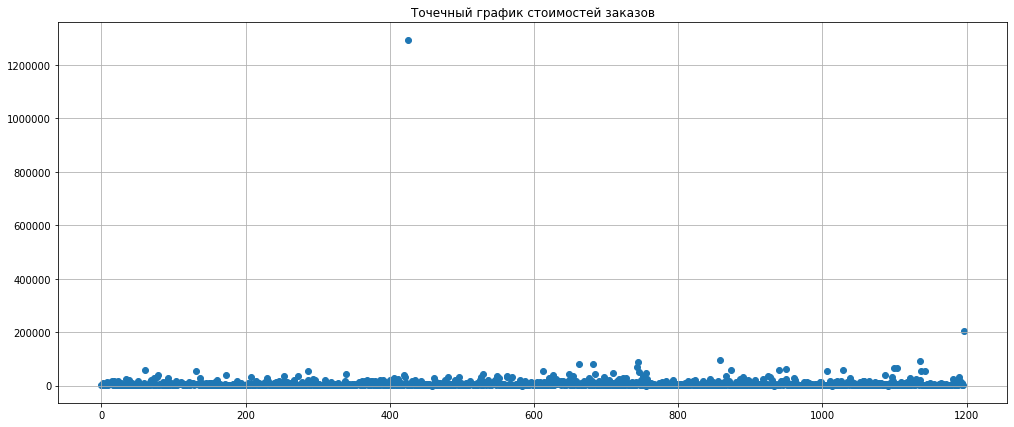

In [38]:
plt.figure(figsize=(17, 7))
plt.title('Точечный график стоимостей заказов')
plt.scatter(pd.Series(range(0, len(orders))), \
            orders['revenue']);
plt.grid()

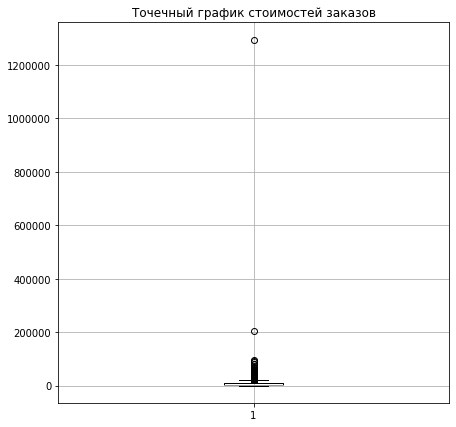

In [39]:
plt.figure(figsize=(7, 7))
plt.title('Точечный график стоимостей заказов')
plt.boxplot(orders['revenue']);
plt.grid()

----
ℹ️ Для подавляющего большенства пользователй сумма заказов составила менее 100 тыс. Рассчитаем выборочные перцентили стоимостей заказов.

<a id='9'><h2>9. Посчет 95-й и 99-й перцентиля стоимости заказов. Выбор границы для определения аномальных пользователей</h2></a>
<a href='#table_of_contents'>В начало</a>

In [40]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

----
ℹ️ Не более 5% посетителей делают заказы на сумму более 28 тыс., не более 1% делают заказы на сумму более 59 тыс. Можно выбрать 28 тыс. как нижнюю границу сумм заказов.

<a id='10'><h2>10. Подсчет статистической значимости различий в конверсии между группами по «сырым» данным</h2></a>
<a href='#table_of_contents'>В начало</a>

- Подготовим таблицу, содежращую данные по группам A и B: количество заказов в день, выручка в день, куммулятивное количество заказов на день, куммулятивная сумма заказов на день.

In [41]:
orders_group = orders.groupby(['date', 'group']).agg({'transaction_id': 'nunique', 'revenue': 'sum'})

In [42]:
# количество заказов в день
orders_per_date = orders_group.pivot_table(index='date', columns='group', values='transaction_id', aggfunc='sum')
#orders_per_date.head(3)

In [43]:
# выручка в день
revenue_per_date = orders_group.pivot_table(index='date', columns='group', values='revenue', aggfunc='sum')
#revenue_per_date.head(3)

In [44]:
# количество посетителей в день
visitors_per_date = visitors.pivot_table(index='date', columns='group', values='visitors', aggfunc='sum')
#visitors_per_date.head(3)

In [45]:
data = orders_per_date\
.merge(cum_orders, how='left', left_index=True, right_index=True, 
       suffixes=('_orders_per_date', '_cum_orders'))\
.merge(revenue_per_date\
       .merge(cum_revenue, how='left', left_index=True, right_index=True, 
           suffixes=('_revenue_per_date', '_cum_revenue')), 
       how='left', left_index=True, right_index=True)\
.merge(visitors_per_date\
       .merge(cum_visitors, how='left', left_index=True, right_index=True, 
           suffixes=('_visitors_per_date', '_cum_visitors')), 
       how='left', left_index=True, right_index=True)

print(data.tail(3))

            A_orders_per_date  B_orders_per_date  A_cum_orders  B_cum_orders  \
date                                                                           
2019-08-29                 22                 20           534           596   
2019-08-30                 11                 24           545           620   
2019-08-31                 12                 20           557           640   

            A_revenue_per_date  B_revenue_per_date  A_cum_revenue  \
date                                                                
2019-08-29              320690              231130        3936510   
2019-08-30               86460              215233        4022970   
2019-08-31               61833              133129        4084803   

            B_cum_revenue  A_visitors_per_date  B_visitors_per_date  \
date                                                                  
2019-08-29        5559398                  577                  531   
2019-08-30        5774631               

----

### Подготовим выборки для проверки различий между группами A и B.

In [46]:
# таблица содержит id посетителей, которые сделали хотя бы один заказ
orders_by_users = orders.groupby(['group', 'buyer_id']).agg({'transaction_id': 'nunique'})
orders_by_users.columns = ['orders']
orders_by_users = orders_by_users.reset_index()
#orders_by_users.shape

In [47]:
sampleA = orders_by_users[orders_by_users['group'] == 'A']['orders']

In [48]:
sampleB = orders_by_users[orders_by_users['group'] == 'B']['orders']

### Проверим выборки на нормальность при помощи критерия Шапиро-Уилка

Чтобы выбрать метод для проверки раличий между выборками, проверим соблюдается ли в выборках условие о нормальном распределении значений.

Сделаем это при при помощи критерия Шапиро-Уилка.

Установим p-value = 0,05.

In [49]:
def shapiro(sample):
    p_val = 0.05
    result = stats.shapiro(sample)[1]

    if result < p_val:
        return "Отвергаем нулевую гипотезу: распределение не нормально"
    else:
        return "Не получилось отвергнуть нулевую гипотезу, всё нормально"

In [50]:
"""
Сформулируем гипотезы:
H0 - нулевая гипотеза состоит в нормальном распределении значений в выборке.
H1 - в выборке не выполняется требование о нормальном распрееделении значений.
"""

print(f'Для групппы A\n{shapiro(sampleA)}')
print(f'Для групппы B\n{shapiro(sampleB)}')

Для групппы A
Отвергаем нулевую гипотезу: распределение не нормально
Для групппы B
Отвергаем нулевую гипотезу: распределение не нормально


ℹ️ Мы видим, что в выборке не соблюдается условие нормального распределения, поэтому параметрический тест t-Стьюдента в этом случае применять некорректно. Для оценки различий между выборками A и B применим непараметрический критерий Манна-Уитни.

----
### Применим критерий Манна-Уитни для оценки различий между выборкой по группе A и по группе B. 

- Добавим в выборку посетителей, которые не сделали заказ, для них количество заказов 0. Расчитаем количество таких посетителей как общее количество посетителей минус количество посетителей, сделавших заказ.

In [51]:
sampleA = pd.concat([sampleA, 
                    pd.Series(0, index=np.arange((data['A_visitors_per_date'].sum() - sampleA.shape[0])), 
                              name='orders')], 
                    axis=0)
sampleA.shape

(18736,)

In [52]:
sampleB = pd.concat([sampleB, 
                    pd.Series(0, index=np.arange((data['B_visitors_per_date'].sum() - sampleB.shape[0])), 
                              name='orders')], 
                    axis=0)
sampleB.shape

(18916,)

Применим критерий Манна-Уитни для оценки различия конверсии между группами по "сырым" данным.

Сформулируем гипотезы:
- H0 - конверсии в группе A и B одинаковые.
- H1 - конверсии в группе A и B не одинаковые.

Критерий значимости p-value 0,05. Если p-value в тесте Манна-Уитни будет меньше 0,05 - это будет основанием, для того чтобы отвергнуть H0 и принять H1.

In [53]:
mannwhitneyu = stats.mannwhitneyu(sampleA, sampleB)[1]
mannwhitneyu.round(3)

0.008

ℹ️ Значение p-value не превышает 0.05 - это говорит о том, что гипотезу о том, что ститистически значимых различий конверсий между группами нет, мы отвергаем. По сырым данным различия между группами есть.

### Найдем относительное различие конверсии между группами A и B.

Конверсия рассчитывается как количество заказов деленое на количество посетителей. Количество заказов - это значение столбца `orders`, количество посетителей - количество строк в выборке. Конверсию найдем как среднее по столбцу `orders`.

In [54]:
rel_def = sampleB.mean()/sampleA.mean() - 1
rel_def.round(3)

0.138

ℹ️ Относительный выигрыш группы B составил 13,8%.

In [55]:
summary = pd.DataFrame([mannwhitneyu, rel_def], 
             index=['mannwhitneyu', 'rel_def'], 
             columns=['original_conversion'])

In [56]:
summary

,original_conversion
mannwhitneyu,0.008396
rel_def,0.138079


<a id='11'><h2>11. Подсчет статистической значимости различий в конверсии между группами по «очищенным» данным</h2></a>

### Очистим данные от аномальных заказов. 

Примем за аномальных пользователей тех, кто:
1. совершил более 2 заказов и 
1. совершил заказы дороже 28 тыс.

In [57]:
# пользователи, совершившие заказы дороже 28 тыс.
usersWithExpensiveOrders = orders[orders['revenue'] >= 28000]['buyer_id']

# пользователи, совершившие заказы больше 2 раз
usersWithManyOrders = orders_by_users[orders_by_users['orders'] >= 2]['buyer_id']

# "аномальные" пользователи
abnormal_users = pd.concat([usersWithExpensiveOrders, usersWithManyOrders], 
                           axis=0).drop_duplicates()
#abnormal_users.head()

In [58]:
abnormal_users.shape[0]

111

In [59]:
abnormal_users = abnormal_users.reset_index(drop=True)
abnormal_users.head()

0    4256040402
1    2947100995
2     787824685
3    3288820196
4    2254586615
Name: buyer_id, dtype: int64

- Удалим заказы этих покупателей из выборки.

In [60]:
filtred_orders_by_users = orders_by_users[np.logical_not(orders_by_users['buyer_id'].isin(abnormal_users))]
filtred_orders_by_users.head()

,group,buyer_id,orders
0,A,8300375,1
1,A,11685486,1
2,A,54447517,1
3,A,66685450,1
4,A,78758296,1


In [61]:
# abnormal_users.append(pd.Series([8300375]), ignore_index=True)

In [62]:
# Проверим, что очищенная выборка не содержит пересекающихся пользователей.
"""A_buyer_id = filtred_orders_by_users.query('group == "A"')['buyer_id']
B_buyer_id = filtred_orders_by_users.query('group == "B"')['buyer_id']
intersection = list(set(A_buyer_id) & set(B_buyer_id))
intersection"""

'A_buyer_id = filtred_orders_by_users.query(\'group == "A"\')[\'buyer_id\']\nB_buyer_id = filtred_orders_by_users.query(\'group == "B"\')[\'buyer_id\']\nintersection = list(set(A_buyer_id) & set(B_buyer_id))\nintersection'

In [63]:
# A_buyer_id.sub(B_buyer_id).

In [64]:
# stats.shapiro(filtred_orders_by_users.query('buyer_id in @intersection')['orders'])

- Добавим в выборку посетителей, которые не сделали заказ, для них количество заказов 0. Расчитаем количество таких посетителей как общее количество посетителей минус количество посетителей, сделавших заказ.

In [65]:
filtred_sampleA = filtred_orders_by_users[filtred_orders_by_users['group'] == 'A']['orders']
filtred_sampleA = pd.concat([filtred_sampleA, 
                             pd.Series(0, index=np.arange((data['A_visitors_per_date'].sum() - filtred_sampleA.shape[0])), 
                                       name='orders')], 
                            axis=0)
#filtred_sampleA.shape

In [66]:
filtred_sampleB = filtred_orders_by_users[filtred_orders_by_users['group'] == 'B']['orders']
filtred_sampleB = pd.concat([filtred_sampleB, 
                             pd.Series(0, index=np.arange((data['B_visitors_per_date'].sum() - filtred_sampleB.shape[0])), 
                                       name='orders')], 
                            axis=0)
#filtred_sampleB.shape

### Применим критерий Манна-Уитни для оценки различий между выборкой по группе A и по группе B. 

Сформулируем гипотезы:
- H0 - конверсии в группе A и B одинаковые.
- H1 - конверсии в группе A и B не одинаковые.

Критерий значимости p-value 0,05. Если p-value в тесте Манна-Уитни будет меньше 0,05 - это будет основанием, для того чтобы отвергнуть H0 и принять H1.

In [67]:
mannwhitneyu = stats.mannwhitneyu(filtred_sampleA, filtred_sampleB)[1]
mannwhitneyu.round(3)

0.008

ℹ️ Значение p-value меньше 0.05 - это говорит о том, что у нас есть основания отвергнуть гипотезу о то, что ститистически значимых различий конверсий между группами нет. В отфильтрованных данных различия между группами присутствуют.

----
- Найдем относительное различие конверсии между группами A и B.

Конверсия рассчитывается как количество заказов деленое на количество посетителей. Количество заказов - это значение столбца `orders`, количество посетителей - количество строк в выборке. Конверсию найдем как среднее по столбцу `orders`.

In [68]:
rel_def = filtred_sampleB.mean()/filtred_sampleA.mean() - 1
rel_def.round(3)

0.168

ℹ️ Конверсия по группе B выше, чем по группе A на 16,8%.

In [69]:
summary['filtred_conversion'] = [mannwhitneyu, rel_def]

In [70]:
summary

,original_conversion,filtred_conversion
mannwhitneyu,0.008396,0.007890
rel_def,0.138079,0.167681


<a id='12'><h2>12. Подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным</h2></a>
<a href='#table_of_contents'>В начало</a>

In [71]:
sampleA = orders[orders['group'] == 'A']['revenue']
sampleB = orders[orders['group'] == 'B']['revenue']

### Применим критерий Манна-Уитни для оценки различий между выборкой по группе A и по группе B. 
Сформулируем гипотезы:
- H0 - средний чек в группе A и B одинаковый.
- H1 - средний чек в группе A и B не одинаковый.

Критерий значимости p-value 0,05. Если p-value в тесте Манна-Уитни будет меньше 0,05 - это будет основанием, для того чтобы отвергнуть H0 и принять H1.

In [72]:
alpha = 0.05
test = lambda p_value: 'Отклоняем нулевую гипотезу' if (p_value < alpha) else 'Не получилось отклонить нулевую гипотезу'

In [73]:
mannwhitneyu = stats.mannwhitneyu(sampleA, sampleB)[1]
f"p-value={mannwhitneyu.round(3)} - {test(mannwhitneyu)}"

'p-value=0.365 - Не получилось отклонить нулевую гипотезу'

ℹ️ Значение p-value больше 0.05 поэтому у нас нет оснований отвергнуть гипотезу о равенстве среднего чека по группам. Среднний чек в группах A и B одинаковый.

----
- Найдем относительное различие среднего чека между группами A и B.

Средний чек рассчитывается как сумма заказов деленое на количество заказов. Сумма заказов - это значение столбца `revenue`, количество заказов - количество строк в выборке. Конверсию найдем как среднее по столбцу `revenue`.

In [74]:
rel_def = sampleB.mean()/sampleA.mean() - 1
rel_def.round(3)

0.259

ℹ️ Относительный преимущество группы B составило 25,9%.

In [75]:
summary['original_avg_check'] = [mannwhitneyu, rel_def]
summary

,original_conversion,filtred_conversion,original_avg_check
mannwhitneyu,0.008396,0.007890,0.364645
rel_def,0.138079,0.167681,0.258714


<a id='13'><h2>13. Подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным</h2></a>
<a href='#table_of_contents'>В начало</a>

In [76]:
filtred_orders = orders[np.logical_not(orders['buyer_id'].isin(abnormal_users))]
filtred_orders.head()

,transaction_id,buyer_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [77]:
filtred_sampleA = filtred_orders[filtred_orders['group'] == 'A']['revenue']
filtred_sampleB = filtred_orders[filtred_orders['group'] == 'B']['revenue']

### Применим критерий Манна-Уитни для оценки различий между выборкой по группе A и по группе B. 

Сформулируем гипотезы:
- H0 - средний чек в группе A и B одинаковый.
- H1 - средний чек в группе A и B не одинаковый.

Критерий значимости p-value 0,05. Если p-value в тесте Манна-Уитни будет меньше 0,05 - это будет основанием, для того чтобы отвергнуть H0 и принять H1.

In [78]:
mannwhitneyu = stats.mannwhitneyu(filtred_sampleA, filtred_sampleB)[1]
f"p-value={mannwhitneyu.round(3)} - {test(mannwhitneyu)}"

'p-value=0.418 - Не получилось отклонить нулевую гипотезу'

ℹ️ Значение p-value больше 0.05 - это говорит о том, что у нет оснований отвергнуть гипотезу о раенстве средних чеков в группе. В отфильтрованных данных различий между группами нет.

----
- Найдем относительное различие в среднем чеке между группами A и B по очищенным данным.

In [79]:
rel_def = filtred_sampleB.mean()/filtred_sampleA.mean() - 1
rel_def.round(3)

-0.006

ℹ️ Конверсия по группе B ниже, чем по группе A на 37,2%.

In [80]:
summary['filtred_avg_check'] = [mannwhitneyu, rel_def]

----

<a id='check'></a>
### Проверка среднего расчета чека по "очищенным" данным.

In [81]:
# для "очищенных" заказов 
# для каждой пары дата+группа посчитаем куммулятивное значение выручки и количества заказов
datesGroups = filtred_orders[['date', 'group']].drop_duplicates().reset_index(drop=True)

ordersAggregated = datesGroups.apply(lambda x: \
filtred_orders[np.logical_and(filtred_orders['date'] <= x['date'], filtred_orders['group'] == x['group'])]\
.agg({'date': 'max', 
      'group': 'max', 
      'revenue': 'sum', 
      'buyer_id': pd.Series.nunique, 
      'transaction_id': pd.Series.nunique}), axis=1)\
.sort_values(by=['date', 'group'])\
.rename(columns={"buyer_id": "buyers", 
                 "transaction_id": "transactions"})

In [82]:
#ordersAggregated.head()

In [83]:
# сводная таблица в строках - даты, в столбцах - группы, в ячейках - куммулятивное значение выручки на указанную дату
filtred_cum_revenue = ordersAggregated.pivot_table(index='date', columns='group', values='revenue', aggfunc='sum')
cum_revenue.columns = ['A', 'B']
filtred_cum_revenue.head()

group,A,B
date,,
2019-08-01,31869,78258
2019-08-02,80572,163122
2019-08-03,193045,230171
2019-08-04,234111,291262
2019-08-05,337044,352920


In [84]:
# сводная таблица в строках - даты, в столбцах - группы, в ячейках - куммулятивное значение количества заказов на указанную дату
filtred_cum_orders = ordersAggregated.pivot_table(index='date', columns='group', values='transactions', aggfunc='sum')
cum_revenue.columns = ['A', 'B']
filtred_cum_orders.head()

group,A,B
date,,
2019-08-01,13,19
2019-08-02,29,37
2019-08-03,53,51
2019-08-04,63,63
2019-08-05,85,84


In [85]:
# куммулятивный средний чек
filtred_avg_check = filtred_cum_revenue/filtred_cum_orders

In [86]:
filtred_avg_check.head()

group,A,B
date,,
2019-08-01,2451.461538,4118.842105
2019-08-02,2778.344828,4408.702703
2019-08-03,3642.358491,4513.156863
2019-08-04,3716.047619,4623.206349
2019-08-05,3965.223529,4201.428571


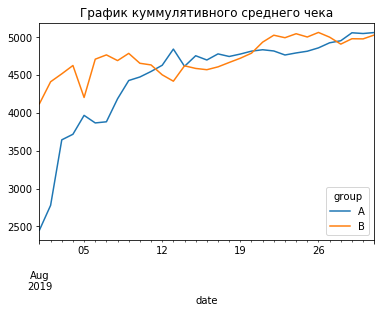

In [87]:
filtred_avg_check.plot.line(title='График куммулятивного среднего чека');

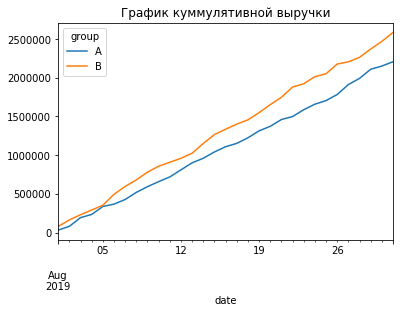

In [88]:
filtred_cum_revenue.plot.line(title='График куммулятивной выручки');

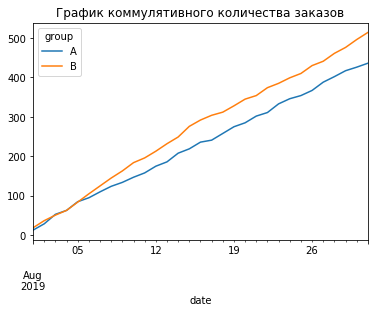

In [89]:
filtred_cum_orders.plot.line(title='График коммулятивного количества заказов');

<a id='14'><h2>14.  Принятие решения по результатам теста</h2></a>
<a href='#table_of_contents'>В начало</a>

Варианты решений: 
1. Остановить тест, зафиксировать победу одной из групп. 
2. Остановить тест, зафиксировать отсутствие различий между группами. 
3. Продолжить тест.

In [90]:
summary

,original_conversion,filtred_conversion,original_avg_check,filtred_avg_check
mannwhitneyu,0.008396,0.007890,0.364645,0.417713
rel_def,0.138079,0.167681,0.258714,-0.006465


----
# Выводы
📌Для конверсии изменение статистически значимо как по "сырым", так и по "очищенным" данным. В сырых данных конверсия по группе B имеет прирост на 13,8%, в очищенных прирост на 16,7%.

📌Нет статистически значимого различия по среднему чеку ни для "сырых", ни для "очищенных" данных. Т.е. средний чек для тестовой и контрольной группы практически одинаковый. По "сырым" данным прирост среднего чека в группе B составил 25,8%, однако в "очищенных" данных для группы B напротив зафиксировано снижение среднего чека на 0,6%. Мы видим, что выбросы в данных очень сильно сместили значение среднего чека.

📌Исходя из обнаруженных данных, тест следует остановить. По очищенным данным мы видим, что и конверсия и средний чек в тестовой и контрольной группе стабилизировались, поэтому дальнейшее проведение теста вряд ли сильно изменит значения. 
По результатам теста зафиксировано статистически значимое отличие конверсии - конверсия в тестовой группе B имеет прирост на 16,7% по сравнению с группой A.